In [24]:
import pandas as pd
chunk_size = 50000
data_chunk = pd.read_csv('training_dataset.csv', chunksize=chunk_size)

df = next(data_chunk)
df.head()

,ID,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,e624ebae-2d2f-41c1-b30f-ca222e1137f0,2,2024-10-09 20:37:37,2024-10-09 21:12:53,1.0,4.16,1.0,N,144,142,...,31.0,1.0,0.5,6.0,0.0,1.0,42.0,2.5,0.0,2116.0
1,b8ee7f2b-74da-4c5a-b959-eb93c8f18ce5,2,2024-06-21 23:04:57,2024-06-21 23:14:06,1.0,1.03,1.0,N,144,79,...,10.0,1.0,0.5,2.0,0.0,1.0,17.0,2.5,0.0,549.0
2,65c77a1f-7c83-4044-99fb-5d61fed94ca9,2,2024-11-23 13:23:13,2024-11-23 13:27:26,2.0,0.62,1.0,N,230,186,...,-5.8,0.0,-0.5,0.0,0.0,-1.0,-9.8,-2.5,0.0,253.0
3,9b353c17-61a5-4bbd-a44c-ecbb381f62cf,2,2024-07-12 21:54:58,2024-07-12 22:07:47,1.0,1.41,1.0,N,113,4,...,12.1,1.0,0.5,2.0,0.0,1.0,19.1,2.5,0.0,769.0
4,b61489e1-e755-4ed9-9550-a8e5086eea2b,2,2024-04-24 11:56:39,2024-04-24 12:15:09,1.0,2.06,1.0,N,161,237,...,17.0,0.0,0.5,4.2,0.0,1.0,25.2,2.5,0.0,1110.0


In [25]:

# Helper to print with prettier colors
class c:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [26]:
nan_values_per_feature = df.isnull().sum()
nan_total = sum(list(df.isnull().sum()))
# Count number of rows that contain at least one NaN
rows_with_nan = df.isnull().any(axis=1).sum()

print(f"The dataset length: \t\t{c.BLUE}{len(df)}{c.END}")
print(f"Total number of missing values: {c.BOLD}{nan_total}{c.END}\n")
print(f"Total number of rows with missing values: {rows_with_nan}\n")

print(f"{c.BOLD}Printing how many entries in each column contain no NaN values{c.END}:")
df.info()


The dataset length: 		50000
Total number of missing values: 24010

Total number of rows with missing values: 4802

Printing how many entries in each column contain no NaN values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     50000 non-null  object 
 1   vendorid               50000 non-null  int64  
 2   tpep_pickup_datetime   50000 non-null  object 
 3   tpep_dropoff_datetime  50000 non-null  object 
 4   passenger_count        45198 non-null  float64
 5   trip_distance          50000 non-null  float64
 6   ratecodeid             45198 non-null  float64
 7   store_and_fwd_flag     45198 non-null  object 
 8   pulocationid           50000 non-null  int64  
 9   dolocationid           50000 non-null  int64  
 10  payment_type           50000 non-null  int64  
 11  fare_amount            50000 no

In [27]:
df.dropna(inplace=True)

In [28]:

column_names = ["ID", "vendorid","tpep_pickup_datetime", "tpep_dropoff_datetime","passenger_count", "p_distance",
                "ratecodeid","store_and_fwd_flag","pulocationid","dolocationid","payment_type","fare_amount",
                "extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","airport_fee","duration"]                 
            
df.columns = column_names
df.head()

print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()
    

List all attributes in the dataset and count how many entries of each kind

ID:
ID
1017f71f-7657-45b4-a855-85112de95204    1
e624ebae-2d2f-41c1-b30f-ca222e1137f0    1
b8ee7f2b-74da-4c5a-b959-eb93c8f18ce5    1
65c77a1f-7c83-4044-99fb-5d61fed94ca9    1
9b353c17-61a5-4bbd-a44c-ecbb381f62cf    1
                                       ..
e95459bb-314e-47f7-a75c-ef4f6b824846    1
66764de3-04ed-4d1f-a4e0-7dab259fff24    1
eef10650-7419-4cfe-ae3c-de556e4f807c    1
d6b0636f-2788-4adf-bd8b-a54a0c7c86bc    1
3a8fb403-5371-4f9f-b9df-2a658ccfc763    1
Name: count, Length: 45198, dtype: int64

vendorid:
vendorid
2    34274
1    10924
Name: count, dtype: int64

tpep_pickup_datetime:
tpep_pickup_datetime
2024-09-19 17:51:23    2
2024-11-10 07:42:40    2
2024-09-15 10:12:53    2
2024-09-27 17:07:53    2
2024-03-13 09:38:28    2
                      ..
2024-11-07 18:05:19    1
2024-01-24 15:08:45    1
2024-10-17 15:52:41    1
2024-09-25 13:13:34    1
2024-02-10 11:43:47    1
Name: count, Length: 45161,

In [29]:
print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()

List all attributes in the dataset and count how many entries of each kind

ID:
ID
1017f71f-7657-45b4-a855-85112de95204    1
e624ebae-2d2f-41c1-b30f-ca222e1137f0    1
b8ee7f2b-74da-4c5a-b959-eb93c8f18ce5    1
65c77a1f-7c83-4044-99fb-5d61fed94ca9    1
9b353c17-61a5-4bbd-a44c-ecbb381f62cf    1
                                       ..
e95459bb-314e-47f7-a75c-ef4f6b824846    1
66764de3-04ed-4d1f-a4e0-7dab259fff24    1
eef10650-7419-4cfe-ae3c-de556e4f807c    1
d6b0636f-2788-4adf-bd8b-a54a0c7c86bc    1
3a8fb403-5371-4f9f-b9df-2a658ccfc763    1
Name: count, Length: 45198, dtype: int64

vendorid:
vendorid
2    34274
1    10924
Name: count, dtype: int64

tpep_pickup_datetime:
tpep_pickup_datetime
2024-09-19 17:51:23    2
2024-11-10 07:42:40    2
2024-09-15 10:12:53    2
2024-09-27 17:07:53    2
2024-03-13 09:38:28    2
                      ..
2024-11-07 18:05:19    1
2024-01-24 15:08:45    1
2024-10-17 15:52:41    1
2024-09-25 13:13:34    1
2024-02-10 11:43:47    1
Name: count, Length: 45161,

In [30]:
df = df.drop(columns=["ID"], axis=1)

In [31]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

df['tpep_pickup_year'] = df['tpep_pickup_datetime'].dt.year
df['tpep_pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['tpep_pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['tpep_pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['tpep_pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['tpep_pickup_second'] = df['tpep_pickup_datetime'].dt.second

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['tpep_dropoff_year'] = df['tpep_dropoff_datetime'].dt.year
df['tpep_dropoff_month'] = df['tpep_dropoff_datetime'].dt.month
df['tpep_dropoff_day'] = df['tpep_dropoff_datetime'].dt.day
df['tpep_dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

df['tpep_dropoff_minute'] = df['tpep_dropoff_datetime'].dt.minute
df['tpep_dropoff_second'] = df['tpep_dropoff_datetime'].dt.second


# Optionally drop the original datetime column
df = df.drop(columns=['tpep_pickup_datetime'], axis=1)
df = df.drop(columns=['tpep_dropoff_datetime'], axis=1)

# df = df.drop(columns=['tpep_pickup_month'], axis=1)
# df = df.drop(columns=['tpep_dropoff_month'], axis=1)


In [32]:
mapping = {'N': 0, 'Y': 1}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(mapping)
print(df.head())


   vendorid  passenger_count  p_distance  ratecodeid  store_and_fwd_flag  \
0         2              1.0        4.16         1.0                   0   
1         2              1.0        1.03         1.0                   0   
2         2              2.0        0.62         1.0                   0   
3         2              1.0        1.41         1.0                   0   
4         2              1.0        2.06         1.0                   0   

   pulocationid  dolocationid  payment_type  fare_amount  extra  ...  \
0           144           142             1         31.0    1.0  ...   
1           144            79             1         10.0    1.0  ...   
2           230           186             2         -5.8    0.0  ...   
3           113             4             1         12.1    1.0  ...   
4           161           237             1         17.0    0.0  ...   

   tpep_pickup_day  tpep_pickup_hour  tpep_pickup_minute  tpep_pickup_second  \
0                9            

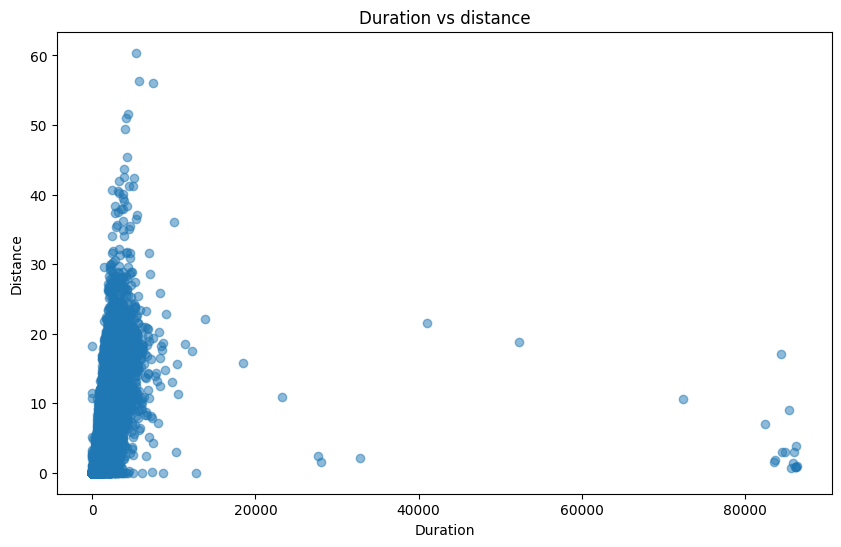

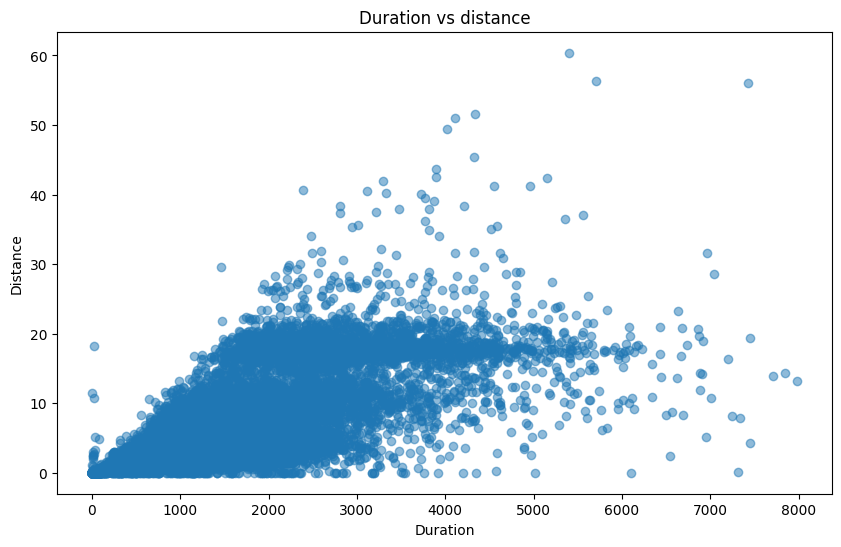

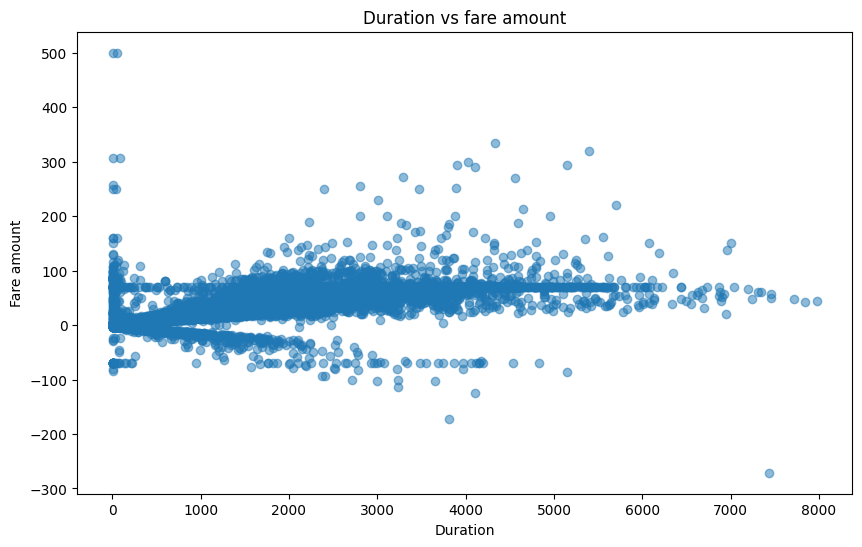

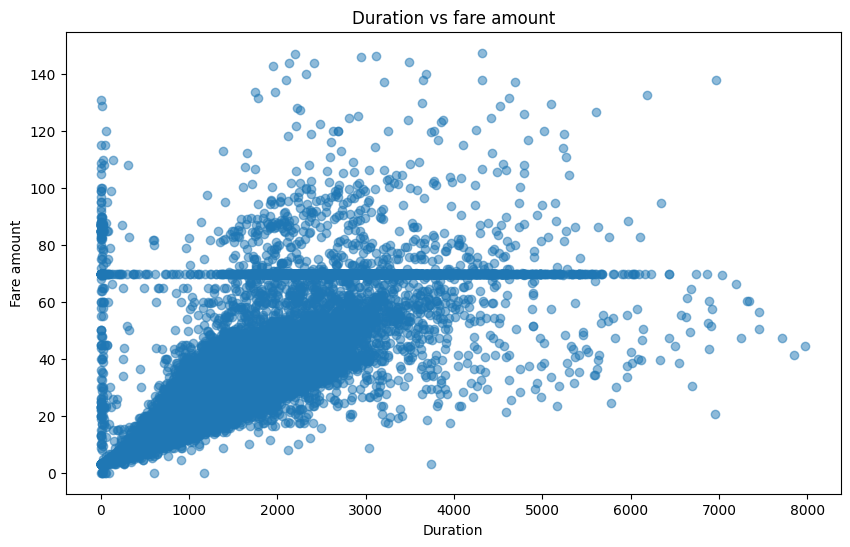

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'p_distance' is the column for distance and 'duration' is the column for time
plt.figure(figsize=(10, 6))
plt.scatter(df['duration'],df['p_distance'], alpha=0.5)
plt.title('Duration vs distance')
plt.xlabel('Duration')
plt.ylabel('Distance')
plt.show()


# Filtering out the outliers
df = df[(df['duration'] < 8000) & (df['duration']>0)]

# Plotting the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(df['duration'],df['p_distance'], alpha=0.5)
plt.title('Duration vs distance')
plt.xlabel('Duration')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df['duration'],df['fare_amount'], alpha=0.5)
plt.title('Duration vs fare amount')
plt.xlabel('Duration')
plt.ylabel('Fare amount')
plt.show()

df = df[(df['fare_amount'] < 150) & (df['fare_amount'] > 0)]

plt.figure(figsize=(10, 6))
plt.scatter(df['duration'],df['fare_amount'], alpha=0.5)
plt.title('Duration vs fare amount')
plt.xlabel('Duration')
plt.ylabel('Fare amount')
plt.show()

df = df.drop(columns=[
    'tpep_pickup_year', 
    'tpep_dropoff_year', 
    'store_and_fwd_flag',
    'airport_fee',
    'payment_type', 
    'congestion_surcharge',
    'passenger_count', 
    'vendorid',
    'improvement_surcharge',
    'tolls_amount',
    'extra',
    'tip_amount',
    'tpep_dropoff_day',
    'tpep_pickup_day',
    'tpep_pickup_month',
    'tpep_pickup_second',
    'tpep_dropoff_second',
    # 'vendorid',
    # 'mta_tax',
    # 'pulocationid',
    # 'tpep_dropoff_month',
    # 'dolocationid',
    # 'total_amount',
    # 'tpep_pickup_minute',
    # 'tpep_dropoff_minute',
    # 'tpep_pickup_hour',
    # 'tpep_dropoff_hour'
    
], axis=1)

X_data = df.drop('duration', axis=1)
y_data = df['duration']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


# Tagit bort

Med alla features: 0.5860777766717762

Utan dessa features i ordning:
- Month: 0.130167677420308
- Second: 0.1300162809946408
- Min: 0.13021313440727722
- Airport fee: 0.12991431207270387
- Extra: 0.12940066092320301
- Store and fwd flag: 0.12940051435027156
- Year: 0.12922283998566508
- Vendorid: 0.12922082486054054
- Pulocation: 0.1292621789281002
- Passengercount: 0.129077988558293
- dolocation: 0.12871978287486396


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Standardize numerical features
num_features = df.select_dtypes(include=["number"]).columns
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_features] = scaler.fit_transform(df[num_features])

# Prepare train/test data
X = df_scaled.drop(columns=["duration"])  # Ensure duration is dropped
y = df_scaled["duration"]  # Predicting duration

# Train-test split (assuming it's done before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train function (fixed)
def train(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    return model.fit(X, y)

MSE: 0.06126850544927622
score:  0.9378384709916893


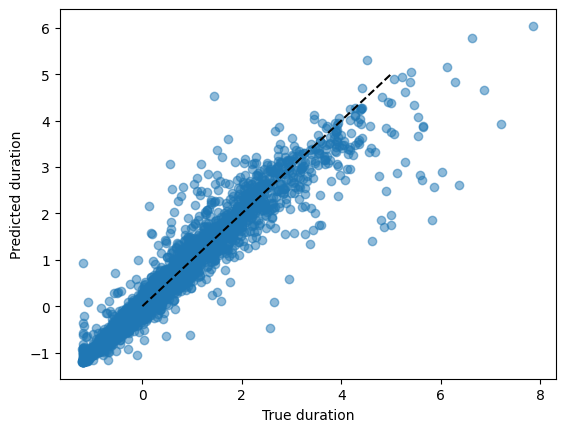

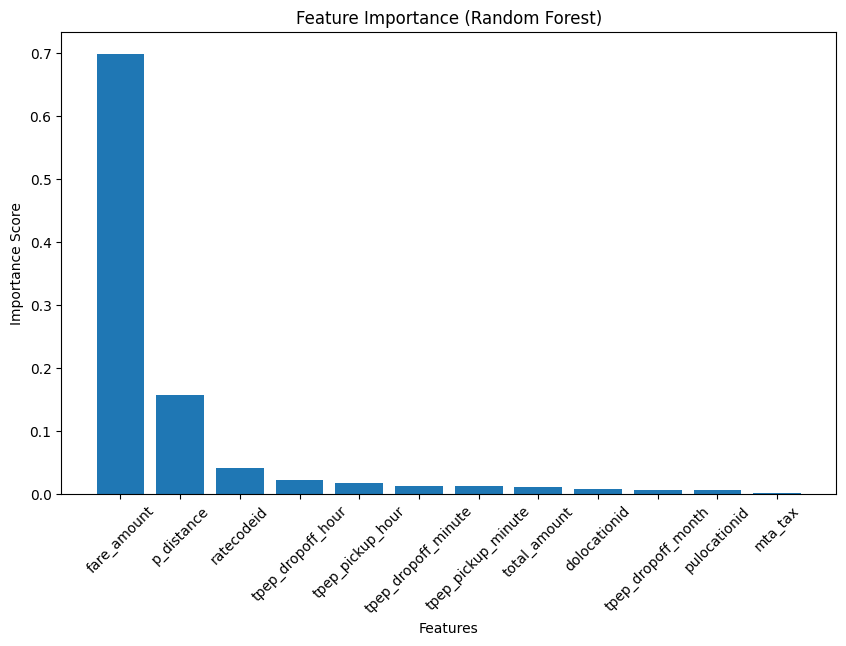

fare_amount - Score: 0.69793
p_distance - Score: 0.15757
ratecodeid - Score: 0.04197
tpep_dropoff_hour - Score: 0.02192
tpep_pickup_hour - Score: 0.01849
tpep_dropoff_minute - Score: 0.01278
tpep_pickup_minute - Score: 0.01273
total_amount - Score: 0.01117
dolocationid - Score: 0.00831
tpep_dropoff_month - Score: 0.00734
pulocationid - Score: 0.00709
mta_tax - Score: 0.00271


In [35]:
# Train model
reg = train(X_train, y_train)

# Evaluate model
y_pred = reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("score: ", reg.score(X_test, y_test))

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 5], [0, 5], '--k')  # Reference line
plt.xlabel("True duration")
plt.ylabel("Predicted duration")
plt.show()

# Feature importance
importances = reg.feature_importances_
feature_names = X_train.columns 

# Sort and plot feature importance
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], tick_label=np.array(feature_names)[indices])
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.show()

# Print sorted feature importance
for i in indices:
    print(f"{feature_names[i]} - Score: {importances[i]:.5f}")